# SIAA: kNN

## Autores: Javier, Laura, Martín, Hugo, Raúl

En este notebook haremos un estudio paso por paso de los datos médicos de un grupo de mujeres.

Enlace del Dataset obtenido: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

#### Columnas de diabetes.csv:

**Pregnancies**
Número de veces embarazada


**Glucose**
Concentración de glucosa en plasma a las 2 horas en una prueba de tolerancia a la glucosa oral


**BloodPressure**
Presión arterial diastólica (mm Hg)


**SkinThickness**
Grosor del pliegue cutáneo del tríceps (mm)


**Insulin**
Insulina sérica a las 2 horas (mu U/ml)


**BMI**
Índice de masa corporal (peso en kg/(altura en m)^2)


**DiabetesPedigreeFunction**
Función de pedigrí de diabetes


**Age**
Edad (años)


**Outcome**
Variable de clase (0 o 1) 268 de 768 son 1, los demás son 0

Importamos todas las librerías necesarias

In [469]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [470]:
# Cargar el dataset
dataset = pd.read_csv('diabetes.csv', delimiter=',')

## K-NN

### Limpieza

Reemplazamos los 0 de las columnas que no deberían tener con la mediana.

In [471]:
# Columnas donde los 0 son inválidos
columnas_con_0 = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Reemplazar 0 con la mediana de cada columna (ignorando los 0)
for col in columnas_con_0:
    mediana = dataset[dataset[col] != 0][col].median()  # Tomamos la mediana sin contar los 0
    dataset[col] = dataset[col].replace(0, mediana)

### División del dataset

In [472]:
# Seleccionar las columnas para el modelo de knn: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.
X = dataset.drop(columns=["Outcome"])
Y = dataset['Outcome']

Utilizando stratify = valor de y, aseguramos que la proporción de las clases en el conjunto de entrenamiento sea igual a la proporción de clases en el conjunto de prueba, si no, la división es aleatoria y puede que se escojan valores que no sean representativos de las proporciones en el conjunto original

In [473]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y)

### Creación del pipeline

Creamos un pipeline en el que escalamos los datos y hacemos el knn con 3 vecinos.

In [474]:
# Utilizamos Una pipeline para encadenar los pasos de preprocesamiento y el modelo, no hace falta hacer OneHotEncoding ya que no hay variables categóricas
pipeline = Pipeline([
    ("escalar", StandardScaler()),
    ("modelo", KNeighborsClassifier(n_neighbors=3))
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

y_pred = pipeline.predict(X_test)

mse_knn = metrics.mean_squared_error(y_test, y_pred)
r2_knn = metrics.r2_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'kNN - MSE: {mse_knn}, R2: {r2_knn}, Precisión: {accuracy}')

kNN - MSE: 0.2792207792207792, R2: -0.22629629629629644, Precisión: 0.7207792207792207


Buscamos el número de vecinos que sea más preciso sin contar hiperparámetros.

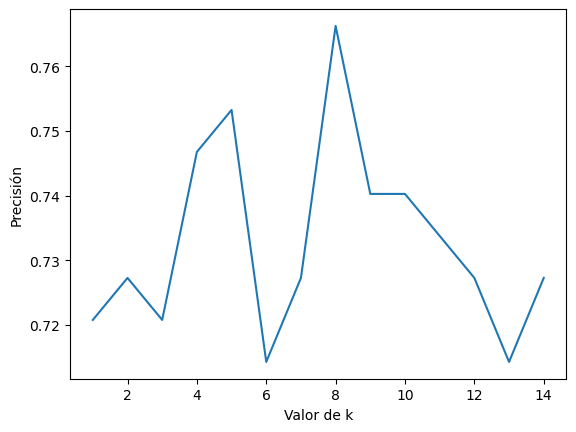

In [475]:
k_range = range(1, 15)
scores = []

for k in k_range:
    pipeline = Pipeline([
        ("escalar", StandardScaler()),
        ("modelo", KNeighborsClassifier(n_neighbors=k))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, scores)
plt.xlabel('Valor de k')
plt.ylabel('Precisión')

plt.show()

Vemos claramente que k = 8 es la mejor opción.

In [476]:
# Ajustamos el número de vecinos al valor con mayor precisión y vemos como se reducen MSE y R2 y aumenta la precisión
pipeline = Pipeline([
    ("escalar", StandardScaler()),
    ("modelo", KNeighborsClassifier(n_neighbors=8))
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

y_pred = pipeline.predict(X_test)

mse_knn = metrics.mean_squared_error(y_test, y_pred)
r2_knn = metrics.r2_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'kNN - MSE: {mse_knn}, R2: {r2_knn}, Precisión: {accuracy}')

kNN - MSE: 0.23376623376623376, R2: -0.026666666666666616, Precisión: 0.7662337662337663


Vemos que tenemos una precisión de 0.766.

### Hiperparámetros

Vamos buscar los mejores hiperparámetros primero con GridSearchCV y luego con RandomizedSearchCV

In [477]:
# Hiperparámetros a ajustar
param_grid = {
    "modelo__n_neighbors": range(1, 10),  # Número de vecinos
    "modelo__weights": ["uniform", "distance"],  # Tipo de ponderación de los vecinos
    "modelo__algorithm": ["auto", "ball_tree"],  # Algoritmo para calcular distancias
    "modelo__metric": ["minkowski", "euclidean"],  # Métricas de distancia
    "modelo__leaf_size": [20, 30, 40], # Tamaño de hoja para el algoritmo de BallTree
    "modelo__p": [1, 2] # Parámetro p para la métrica de Minkowski
}

Buscamos con el RandomizedSearchCV.

In [478]:
grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', random_state=42, n_iter=20)
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados por RandomizedSearchCV:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados por RandomizedSearchCV:
{'modelo__weights': 'uniform', 'modelo__p': 1, 'modelo__n_neighbors': 9, 'modelo__metric': 'minkowski', 'modelo__leaf_size': 40, 'modelo__algorithm': 'ball_tree'}


Buscamos con el GridSearchCV.

In [479]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

Mejores hiperparámetros encontrados por GridSearchCV:
{'modelo__algorithm': 'auto', 'modelo__leaf_size': 20, 'modelo__metric': 'minkowski', 'modelo__n_neighbors': 7, 'modelo__p': 1, 'modelo__weights': 'uniform'}


Aplicamos los parámetros del GridSearchCV al modelo de K-NN porque asegura los mejores hiperparámetros.

In [480]:
# Ajustamos el número de vecinos al valor con mayor precisión y vemos como se reducen MSE y R2 y aumenta la precisión
pipeline = Pipeline([
    ("escalar", StandardScaler()),
    ("modelo", KNeighborsClassifier(n_neighbors=9, weights='uniform', p=1, leaf_size=20, algorithm='auto', metric='minkowski'))
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

y_pred = pipeline.predict(X_test)

mse_knn = metrics.mean_squared_error(y_test, y_pred)
r2_knn = metrics.r2_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'kNN - MSE: {mse_knn}, R2: {r2_knn}, Precisión: {accuracy}')

kNN - MSE: 0.23376623376623376, R2: -0.026666666666666616, Precisión: 0.7662337662337663


Vemos que al meter los hiperparámetros el mejor número de vecinos es 9.

Se mira la probabilidad de que un paciente tenga o no Diabetes, contando con los 10 primeros casos.

In [481]:
y_pred2 = pipeline.predict(X_test)
y_pred2

# podemos también usar predict_proba para tener las probabilidades de clase
probabilidades = pipeline.predict_proba(X_test)
print(probabilidades[:10])

[[0.44444444 0.55555556]
 [0.88888889 0.11111111]
 [0.77777778 0.22222222]
 [0.66666667 0.33333333]
 [0.77777778 0.22222222]
 [0.88888889 0.11111111]
 [0.77777778 0.22222222]
 [0.33333333 0.66666667]
 [1.         0.        ]
 [0.22222222 0.77777778]]


## Regresión logística

Implementamos un modelo de Regresión logística para clasificar si un paciente tiene o no diabetes basado en las columnas seleccionadas en el dataset, sacando a su vez: la precisión, la matriz
de confusión y la gráfica de la Curva ROC.

Accuracy: 70.13%

Matriz de Confusión:
[[81 19]
 [27 27]]


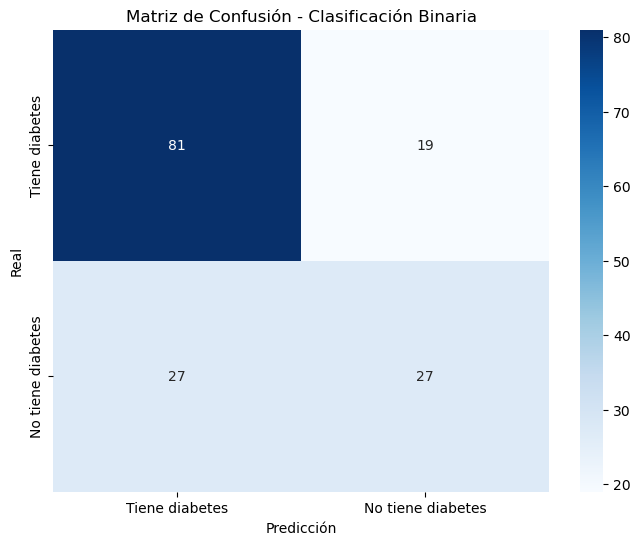

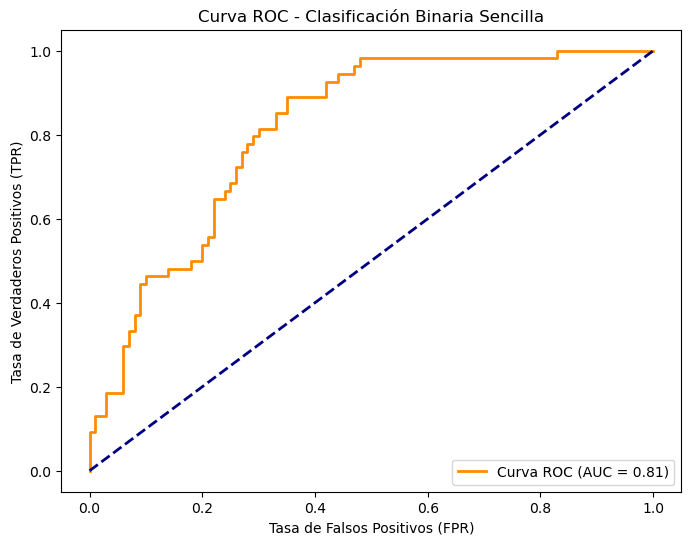

AUC: 0.81


In [482]:
# Crear el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=10000)

# Entrenar el modelo con el conjunto de entrenamiento
log_reg.fit(X_train, y_train)

# Realizar predicciones con el conjunto de prueba
Y_pred = log_reg.predict(X_test)

# Calcular Accuracy
accuracy = accuracy_score(y_test, Y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Obtener la matriz de confusión
cm = confusion_matrix(y_test, Y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Tiene diabetes", "No tiene diabetes"], yticklabels=["Tiene diabetes", "No tiene diabetes"])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Realizar predicciones con el conjunto de prueba (probabilidades) para ROC
Y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva (1)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_prob)

# Calcular el AUC (Área Bajo la Curva)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea aleatoria (AUC = 0.5)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Clasificación Binaria Sencilla')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

Realizamos una validación cruzada para evaluar el rendimiento del modelo de Regresión Logística y visualizamos la gráfica de la validación cruzada

Scores en cada fold: [0.75974026 0.74025974 0.78571429 0.79738562 0.77777778]
Accuracy promedio: 0.77
Desviación estándar: 0.02


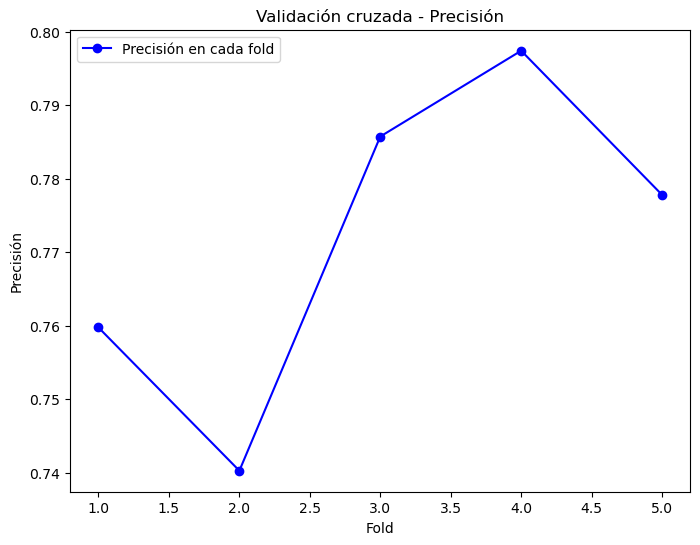

In [483]:
# Realizar la validación cruzada
scores = cross_val_score(log_reg, X, Y, cv=5)

print(f'Scores en cada fold: {scores}')
print(f'Accuracy promedio: {scores.mean():.2f}')
print(f'Desviación estándar: {scores.std():.2f}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', color='b', label='Precisión en cada fold')
plt.xlabel('Fold')
plt.ylabel('Precisión')
plt.title('Validación cruzada - Precisión')
plt.legend()
plt.show()

## Conclusiones:
El modelo de K-NN se ajusta mejor a los datos ya que tiene una precisión de 76.62% mientras que la regresión logística tiene una precisión del 70.13%.

## Problemas encontrados:
El dataset tiene muchos 0 donde no debería haberlos, ya que una persona viva no puede tener 0 de presión arterial, de glucosa, de grosor de la piel, insulina o de índice de masa corporal.
